In [134]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D, MaxPooling1D
from keras.layers import LSTM, Bidirectional, Dropout, Embedding, GRU
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD  # note add tensorflow
from sklearn.metrics import roc_auc_score  # for evaluating classifier
import tensorflow as tf  # for tensorflow metrics


In [86]:
# load data
file_path = './datafiles/blindPosts/'
files = [file_path + f for f in os.listdir(file_path)]
df = pd.concat([pd.read_csv(f, parse_dates=True).iloc[:, 1:]
                for f in files])
df = df.set_index('company')

# change data type
df = df.rename({'post_like': 'likes', 'post_comment': 'comments'}, axis=1)
df['post_firm'] = df['post_firm'].map(lambda x: str(x).replace('/company/', '').rstrip('/'))
df['likes'] = df['likes'].map(lambda x: str(x).replace(',', ''))
df['comments'] = df['comments'].map(lambda x: str(x).replace(',', ''))
df['likes'] = pd.to_numeric(df['likes'])
df['comments'] = pd.to_numeric(df['comments'])
df['post_timestamp'] = pd.to_datetime(df['post_timestamp'])
df = df.reset_index().set_index(
    ['company', 'post_timestamp']).sort_index().reset_index()

# let's generate labels popular and controversial based on likes and comments 
df[~df['post_text'].duplicated()]
df['popular'] = np.where(df['likes'] > df['likes'].quantile(0.99), 1, 0)
df['controversial'] = np.where(df['comments'] > df['comments'].quantile(0.99), 1, 0)
data = df[['post_text', 'post_firm', 'popular', 'controversial']] # keep poster company if available

In [87]:
# imbalanced data correction
# examine imbalance
neg, pos = np.bincount(df['popular'])
total = neg + pos
INITIAL_BIAS = np.log([pos/neg])
print("Positive rate:", round(pos/total*100,3), '%')
# class weights
# scaling by total/2 helps keep the loss to a similar magnitude.
# the sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)
CLASS_WEIGHT = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Positive rate: 0.99 %
Weight for class 0: 0.51
Weight for class 1: 50.49


In [135]:
MAX_SEQUENCE_LENGTH = 400
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 2048  # make sure each batch has chance of obtaining positive examples
EPOCHS = 50
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

np.random.seed(7)


In [91]:
# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('./datafiles/glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

# prepare text samples and their labels
print('Loading in comments')
train = data
sentences = train['post_text'].fillna('DUMMY_VALUE').values
possible_labels = ['controversial', 'popular']
targets = train[possible_labels].values  # N * 2 matrix

s = sorted(len(s) for s in sentences)
print("median sequence length: ", s[len(s)//2])
print("max sequence length: ", s[-1])
print("min sequence length: ", s[0])
# convert the sentences (strings) to ints
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
# print(sequences[0])
# get word -> int mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))
# pad sequences so that we get N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor: ', data.shape)


Loading word vectors...
Found 400000 word vectors.
Loading in comments
median sequence length:  276
max sequence length:  24302
min sequence length:  1
Found 134858 unique tokens.
Shape of data tensor:  (241157, 400)


In [136]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all zeros.
            embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False as to keep the embeddings fixed
embedding_layer = Embedding(
    num_words,
    EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False,  # keep the embeddings fixed
)
print('Building model...')
# train a lstm network with a single lstm
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = LSTM(15, return_sequences=True)(x) # could change RNN model
x = GlobalMaxPooling1D()(x)
output = Dense(len(possible_labels), activation='sigmoid')(x) 


Filling pre-trained embeddings...
Building model...


In [137]:
model = Model(input_, output)
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.01),
    metrics= METRICS # accuracy is not good for this task 
)


# set callbacks to prevent overfit and save as checkpts
checkpoint_path = './checkpoint/cp.cpkt'
checkpoint_dir = os.path.dirname(checkpoint_path)
CALL_BACKS = [
    # how many epochs without improvement you allow before the cb interferes
    EarlyStopping(monitor='val_loss', patience=20,
                  mode='min', min_delta=0.0001),
    ModelCheckpoint(checkpoint_path, monitor='val_loss',
                    save_best_only=True, mode='min'
                    ),
]

print('Training model...')
r = model.fit(
    data,
    targets,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT,
    class_weight = CLASS_WEIGHT,
    callbacks = [CALL_BACKS] # prevents overfit 
)

Training model...
Epoch 1/50
95/95 [==============================] - ETA: 0s - loss: 0.1810 - tp: 550.0000 - fp: 8988.0000 - tn: 373123.0000 - fn: 3189.0000 - accuracy: 0.9684 - precision: 0.0577 - recall: 0.1471 - auc: 0.5742 - prc: 0.0387

INFO:tensorflow:Assets written to: ./checkpoint/cp.cpkt/assets


INFO:tensorflow:Assets written to: ./checkpoint/cp.cpkt/assets


95/95 [==============================] - 309s 3s/step - loss: 0.1810 - tp: 550.0000 - fp: 8988.0000 - tn: 373123.0000 - fn: 3189.0000 - accuracy: 0.9684 - precision: 0.0577 - recall: 0.1471 - auc: 0.5742 - prc: 0.0387 - val_loss: 0.1813 - val_tp: 315.0000 - val_fp: 4729.0000 - val_tn: 90676.0000 - val_fn: 744.0000 - val_accuracy: 0.9433 - val_precision: 0.0625 - val_recall: 0.2975 - val_auc: 0.5696 - val_prc: 0.0708
Epoch 2/50
95/95 [==============================] - ETA: 0s - loss: 0.1173 - tp: 1097.0000 - fp: 9942.0000 - tn: 372169.0000 - fn: 2642.0000 - accuracy: 0.9674 - precision: 0.0994 - recall: 0.2934 - auc: 0.5882 - prc: 0.0730

INFO:tensorflow:Assets written to: ./checkpoint/cp.cpkt/assets


INFO:tensorflow:Assets written to: ./checkpoint/cp.cpkt/assets


95/95 [==============================] - 359s 4s/step - loss: 0.1173 - tp: 1097.0000 - fp: 9942.0000 - tn: 372169.0000 - fn: 2642.0000 - accuracy: 0.9674 - precision: 0.0994 - recall: 0.2934 - auc: 0.5882 - prc: 0.0730 - val_loss: 0.1167 - val_tp: 264.0000 - val_fp: 2308.0000 - val_tn: 93097.0000 - val_fn: 795.0000 - val_accuracy: 0.9678 - val_precision: 0.1026 - val_recall: 0.2493 - val_auc: 0.5705 - val_prc: 0.0774
Epoch 3/50
95/95 [==============================] - ETA: 0s - loss: 0.0982 - tp: 1151.0000 - fp: 8417.0000 - tn: 373694.0000 - fn: 2588.0000 - accuracy: 0.9715 - precision: 0.1203 - recall: 0.3078 - auc: 0.6087 - prc: 0.0930

INFO:tensorflow:Assets written to: ./checkpoint/cp.cpkt/assets


INFO:tensorflow:Assets written to: ./checkpoint/cp.cpkt/assets


95/95 [==============================] - 365s 4s/step - loss: 0.0982 - tp: 1151.0000 - fp: 8417.0000 - tn: 373694.0000 - fn: 2588.0000 - accuracy: 0.9715 - precision: 0.1203 - recall: 0.3078 - auc: 0.6087 - prc: 0.0930 - val_loss: 0.0944 - val_tp: 232.0000 - val_fp: 1435.0000 - val_tn: 93970.0000 - val_fn: 827.0000 - val_accuracy: 0.9766 - val_precision: 0.1392 - val_recall: 0.2191 - val_auc: 0.5695 - val_prc: 0.0824
Epoch 4/50
95/95 [==============================] - ETA: 0s - loss: 0.0855 - tp: 1164.0000 - fp: 6999.0000 - tn: 375112.0000 - fn: 2575.0000 - accuracy: 0.9752 - precision: 0.1426 - recall: 0.3113 - auc: 0.6144 - prc: 0.1110

INFO:tensorflow:Assets written to: ./checkpoint/cp.cpkt/assets


INFO:tensorflow:Assets written to: ./checkpoint/cp.cpkt/assets


95/95 [==============================] - 287s 3s/step - loss: 0.0855 - tp: 1164.0000 - fp: 6999.0000 - tn: 375112.0000 - fn: 2575.0000 - accuracy: 0.9752 - precision: 0.1426 - recall: 0.3113 - auc: 0.6144 - prc: 0.1110 - val_loss: 0.0837 - val_tp: 216.0000 - val_fp: 1144.0000 - val_tn: 94261.0000 - val_fn: 843.0000 - val_accuracy: 0.9794 - val_precision: 0.1588 - val_recall: 0.2040 - val_auc: 0.5828 - val_prc: 0.0911
Epoch 5/50
95/95 [==============================] - 222s 2s/step - loss: 0.0783 - tp: 1217.0000 - fp: 6995.0000 - tn: 375116.0000 - fn: 2522.0000 - accuracy: 0.9753 - precision: 0.1482 - recall: 0.3255 - auc: 0.6497 - prc: 0.1240 - val_loss: 0.0925 - val_tp: 291.0000 - val_fp: 1624.0000 - val_tn: 93781.0000 - val_fn: 768.0000 - val_accuracy: 0.9752 - val_precision: 0.1520 - val_recall: 0.2748 - val_auc: 0.6297 - val_prc: 0.1094
Epoch 6/50
95/95 [==============================] - ETA: 0s - loss: 0.0708 - tp: 1216.0000 - fp: 6121.0000 - tn: 375990.0000 - fn: 2523.0000 - accu

INFO:tensorflow:Assets written to: ./checkpoint/cp.cpkt/assets


INFO:tensorflow:Assets written to: ./checkpoint/cp.cpkt/assets


95/95 [==============================] - 205s 2s/step - loss: 0.0708 - tp: 1216.0000 - fp: 6121.0000 - tn: 375990.0000 - fn: 2523.0000 - accuracy: 0.9776 - precision: 0.1657 - recall: 0.3252 - auc: 0.7066 - prc: 0.1439 - val_loss: 0.0789 - val_tp: 249.0000 - val_fp: 1118.0000 - val_tn: 94287.0000 - val_fn: 810.0000 - val_accuracy: 0.9800 - val_precision: 0.1822 - val_recall: 0.2351 - val_auc: 0.6693 - val_prc: 0.1160
Epoch 7/50
95/95 [==============================] - ETA: 0s - loss: 0.0664 - tp: 1231.0000 - fp: 6063.0000 - tn: 376048.0000 - fn: 2508.0000 - accuracy: 0.9778 - precision: 0.1688 - recall: 0.3292 - auc: 0.7409 - prc: 0.1651

INFO:tensorflow:Assets written to: ./checkpoint/cp.cpkt/assets


INFO:tensorflow:Assets written to: ./checkpoint/cp.cpkt/assets


95/95 [==============================] - 222s 2s/step - loss: 0.0664 - tp: 1231.0000 - fp: 6063.0000 - tn: 376048.0000 - fn: 2508.0000 - accuracy: 0.9778 - precision: 0.1688 - recall: 0.3292 - auc: 0.7409 - prc: 0.1651 - val_loss: 0.0773 - val_tp: 257.0000 - val_fp: 1213.0000 - val_tn: 94192.0000 - val_fn: 802.0000 - val_accuracy: 0.9791 - val_precision: 0.1748 - val_recall: 0.2427 - val_auc: 0.7127 - val_prc: 0.1334
Epoch 8/50
95/95 [==============================] - 217s 2s/step - loss: 0.0589 - tp: 1271.0000 - fp: 5098.0000 - tn: 377013.0000 - fn: 2468.0000 - accuracy: 0.9804 - precision: 0.1996 - recall: 0.3399 - auc: 0.7759 - prc: 0.1886 - val_loss: 0.0848 - val_tp: 295.0000 - val_fp: 1586.0000 - val_tn: 93819.0000 - val_fn: 764.0000 - val_accuracy: 0.9756 - val_precision: 0.1568 - val_recall: 0.2786 - val_auc: 0.7137 - val_prc: 0.1556
Epoch 9/50
95/95 [==============================] - ETA: 0s - loss: 0.0581 - tp: 1250.0000 - fp: 5241.0000 - tn: 376870.0000 - fn: 2489.0000 - accu

INFO:tensorflow:Assets written to: ./checkpoint/cp.cpkt/assets


INFO:tensorflow:Assets written to: ./checkpoint/cp.cpkt/assets


95/95 [==============================] - 204s 2s/step - loss: 0.0581 - tp: 1250.0000 - fp: 5241.0000 - tn: 376870.0000 - fn: 2489.0000 - accuracy: 0.9800 - precision: 0.1926 - recall: 0.3343 - auc: 0.7642 - prc: 0.1951 - val_loss: 0.0750 - val_tp: 262.0000 - val_fp: 1086.0000 - val_tn: 94319.0000 - val_fn: 797.0000 - val_accuracy: 0.9805 - val_precision: 0.1944 - val_recall: 0.2474 - val_auc: 0.7133 - val_prc: 0.1551
Epoch 10/50
95/95 [==============================] - 216s 2s/step - loss: 0.0523 - tp: 1255.0000 - fp: 4535.0000 - tn: 377576.0000 - fn: 2484.0000 - accuracy: 0.9818 - precision: 0.2168 - recall: 0.3357 - auc: 0.7883 - prc: 0.2222 - val_loss: 0.0905 - val_tp: 290.0000 - val_fp: 1808.0000 - val_tn: 93597.0000 - val_fn: 769.0000 - val_accuracy: 0.9733 - val_precision: 0.1382 - val_recall: 0.2738 - val_auc: 0.7235 - val_prc: 0.1561
Epoch 11/50
95/95 [==============================] - ETA: 0s - loss: 0.0513 - tp: 1226.0000 - fp: 4522.0000 - tn: 377589.0000 - fn: 2513.0000 - ac

INFO:tensorflow:Assets written to: ./checkpoint/cp.cpkt/assets


INFO:tensorflow:Assets written to: ./checkpoint/cp.cpkt/assets


95/95 [==============================] - 292s 3s/step - loss: 0.0513 - tp: 1226.0000 - fp: 4522.0000 - tn: 377589.0000 - fn: 2513.0000 - accuracy: 0.9818 - precision: 0.2133 - recall: 0.3279 - auc: 0.7826 - prc: 0.2261 - val_loss: 0.0655 - val_tp: 244.0000 - val_fp: 825.0000 - val_tn: 94580.0000 - val_fn: 815.0000 - val_accuracy: 0.9830 - val_precision: 0.2283 - val_recall: 0.2304 - val_auc: 0.7492 - val_prc: 0.1625
Epoch 12/50
95/95 [==============================] - 314s 3s/step - loss: 0.0455 - tp: 1288.0000 - fp: 3709.0000 - tn: 378402.0000 - fn: 2451.0000 - accuracy: 0.9840 - precision: 0.2578 - recall: 0.3445 - auc: 0.7989 - prc: 0.2434 - val_loss: 0.0678 - val_tp: 262.0000 - val_fp: 844.0000 - val_tn: 94561.0000 - val_fn: 797.0000 - val_accuracy: 0.9830 - val_precision: 0.2369 - val_recall: 0.2474 - val_auc: 0.7313 - val_prc: 0.1706
Epoch 13/50
95/95 [==============================] - 285s 3s/step - loss: 0.0480 - tp: 1281.0000 - fp: 4005.0000 - tn: 378106.0000 - fn: 2458.0000 -

INFO:tensorflow:Assets written to: ./checkpoint/cp.cpkt/assets


INFO:tensorflow:Assets written to: ./checkpoint/cp.cpkt/assets


95/95 [==============================] - 322s 3s/step - loss: 0.0394 - tp: 1282.0000 - fp: 2915.0000 - tn: 379196.0000 - fn: 2457.0000 - accuracy: 0.9861 - precision: 0.3055 - recall: 0.3429 - auc: 0.8050 - prc: 0.2689 - val_loss: 0.0578 - val_tp: 237.0000 - val_fp: 499.0000 - val_tn: 94906.0000 - val_fn: 822.0000 - val_accuracy: 0.9863 - val_precision: 0.3220 - val_recall: 0.2238 - val_auc: 0.7564 - val_prc: 0.1976
Epoch 15/50
95/95 [==============================] - 291s 3s/step - loss: 0.0355 - tp: 1280.0000 - fp: 2429.0000 - tn: 379682.0000 - fn: 2459.0000 - accuracy: 0.9873 - precision: 0.3451 - recall: 0.3423 - auc: 0.8185 - prc: 0.2994 - val_loss: 0.0595 - val_tp: 247.0000 - val_fp: 538.0000 - val_tn: 94867.0000 - val_fn: 812.0000 - val_accuracy: 0.9860 - val_precision: 0.3146 - val_recall: 0.2332 - val_auc: 0.7530 - val_prc: 0.2042
Epoch 16/50
95/95 [==============================] - ETA: 0s - loss: 0.0333 - tp: 1315.0000 - fp: 2167.0000 - tn: 379944.0000 - fn: 2424.0000 - accu

INFO:tensorflow:Assets written to: ./checkpoint/cp.cpkt/assets


INFO:tensorflow:Assets written to: ./checkpoint/cp.cpkt/assets


95/95 [==============================] - 416s 4s/step - loss: 0.0333 - tp: 1315.0000 - fp: 2167.0000 - tn: 379944.0000 - fn: 2424.0000 - accuracy: 0.9881 - precision: 0.3777 - recall: 0.3517 - auc: 0.8185 - prc: 0.3166 - val_loss: 0.0566 - val_tp: 245.0000 - val_fp: 473.0000 - val_tn: 94932.0000 - val_fn: 814.0000 - val_accuracy: 0.9867 - val_precision: 0.3412 - val_recall: 0.2314 - val_auc: 0.7674 - val_prc: 0.2124
Epoch 17/50
95/95 [==============================] - 388s 4s/step - loss: 0.0307 - tp: 1334.0000 - fp: 1802.0000 - tn: 380309.0000 - fn: 2405.0000 - accuracy: 0.9891 - precision: 0.4254 - recall: 0.3568 - auc: 0.8282 - prc: 0.3412 - val_loss: 0.0587 - val_tp: 262.0000 - val_fp: 560.0000 - val_tn: 94845.0000 - val_fn: 797.0000 - val_accuracy: 0.9859 - val_precision: 0.3187 - val_recall: 0.2474 - val_auc: 0.7656 - val_prc: 0.2166
Epoch 18/50
95/95 [==============================] - ETA: 0s - loss: 0.0295 - tp: 1380.0000 - fp: 1739.0000 - tn: 380372.0000 - fn: 2359.0000 - accu

INFO:tensorflow:Assets written to: ./checkpoint/cp.cpkt/assets


INFO:tensorflow:Assets written to: ./checkpoint/cp.cpkt/assets


95/95 [==============================] - 341s 4s/step - loss: 0.0295 - tp: 1380.0000 - fp: 1739.0000 - tn: 380372.0000 - fn: 2359.0000 - accuracy: 0.9894 - precision: 0.4424 - recall: 0.3691 - auc: 0.8295 - prc: 0.3516 - val_loss: 0.0552 - val_tp: 239.0000 - val_fp: 385.0000 - val_tn: 95020.0000 - val_fn: 820.0000 - val_accuracy: 0.9875 - val_precision: 0.3830 - val_recall: 0.2257 - val_auc: 0.7596 - val_prc: 0.2320
Epoch 19/50
95/95 [==============================] - 312s 3s/step - loss: 0.0283 - tp: 1359.0000 - fp: 1560.0000 - tn: 380551.0000 - fn: 2380.0000 - accuracy: 0.9898 - precision: 0.4656 - recall: 0.3635 - auc: 0.8314 - prc: 0.3645 - val_loss: 0.0744 - val_tp: 322.0000 - val_fp: 1164.0000 - val_tn: 94241.0000 - val_fn: 737.0000 - val_accuracy: 0.9803 - val_precision: 0.2167 - val_recall: 0.3041 - val_auc: 0.7583 - val_prc: 0.1947
Epoch 20/50
95/95 [==============================] - 353s 4s/step - loss: 0.0313 - tp: 1367.0000 - fp: 2216.0000 - tn: 379895.0000 - fn: 2372.0000 

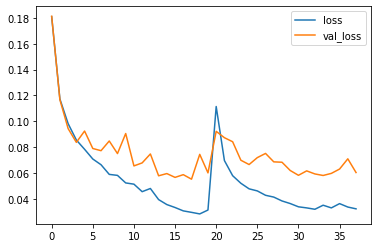

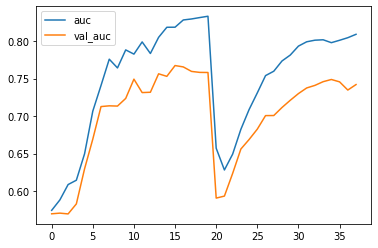

In [138]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


# plot some data
plt.plot(r.history['auc'], label='auc')
plt.plot(r.history['val_auc'], label='val_auc')
plt.legend()
plt.show()

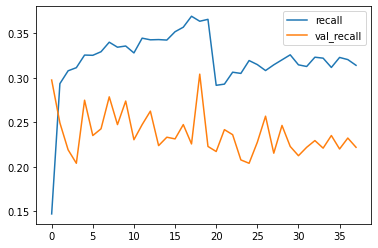

In [139]:
# plot some data
plt.plot(r.history['recall'], label='recall')
plt.plot(r.history['val_recall'], label='val_recall')
plt.legend()
plt.show()

True Negatives:  tf.Tensor(236310, shape=(), dtype=int32)
False Positives:  tf.Tensor(2459, shape=(), dtype=int32)
False Negatives:  tf.Tensor(965, shape=(), dtype=int32)
True Positives:  tf.Tensor(1423, shape=(), dtype=int32)
Total Positive:  2388


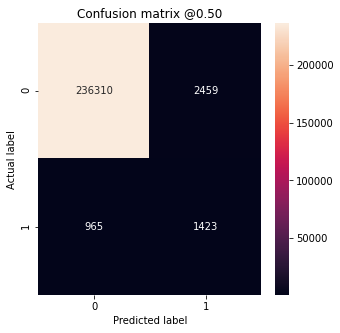

In [140]:
def plot_cm(labels, predictions, p=0.5):
  cm = tf.math.confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])
  print('Total Positive: ', np.sum(cm[1]))

p = model.predict(data)
plot_cm(targets[:, 1], p[:, 1]) 

In [150]:
# save model if performing better than old model 
# model.save('./model/blind_lstm_v2.h5')

In [141]:
new_model = tf.keras.models.load_model('./model/blind_lstm/blind_lstm.h5')
p = new_model.predict(data)
plot_cm(targets[:, 1], p[:, 1]) 
auc = roc_auc_score(targets[:, 1], p[:, 1])
print(auc) # best peforming mode so far 

True Negatives:  tf.Tensor(237781, shape=(), dtype=int32)
False Positives:  tf.Tensor(988, shape=(), dtype=int32)
False Negatives:  tf.Tensor(769, shape=(), dtype=int32)
True Positives:  tf.Tensor(1619, shape=(), dtype=int32)
Total Positive:  2388


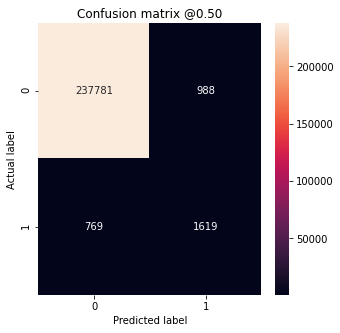

In [149]:
plot_cm(targets[:, 1], p[:, 1]) 